In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 100

ng =6

ng_refs = (/ 6 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 600 /) 

t_refs = (/ 250 /) 

tsfc =300

vstar = 620

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66 , 1.66/

data wgt
     &     /0.8 , 0.8 , 0.8 , 0.6,
     &     0.6 , 0.9/

atmosphere_profiles/trp75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

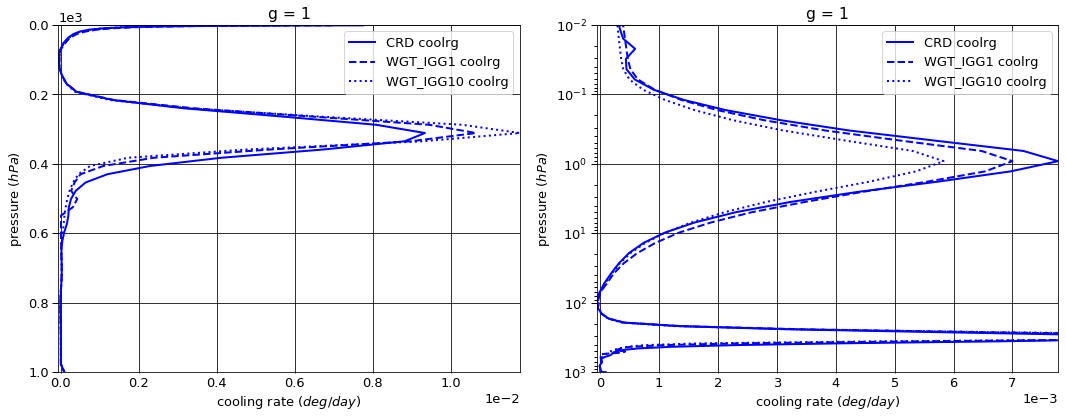

# Figure: cooling rate g-group 2

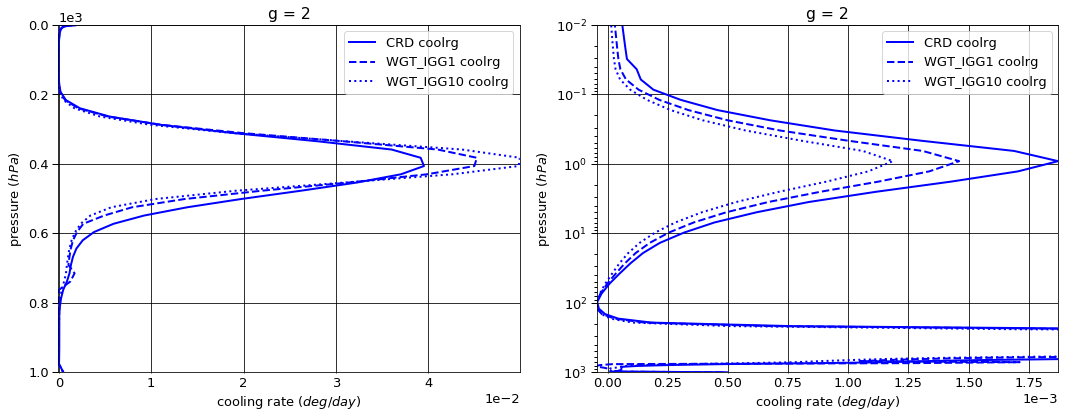

# Figure: cooling rate g-group 3

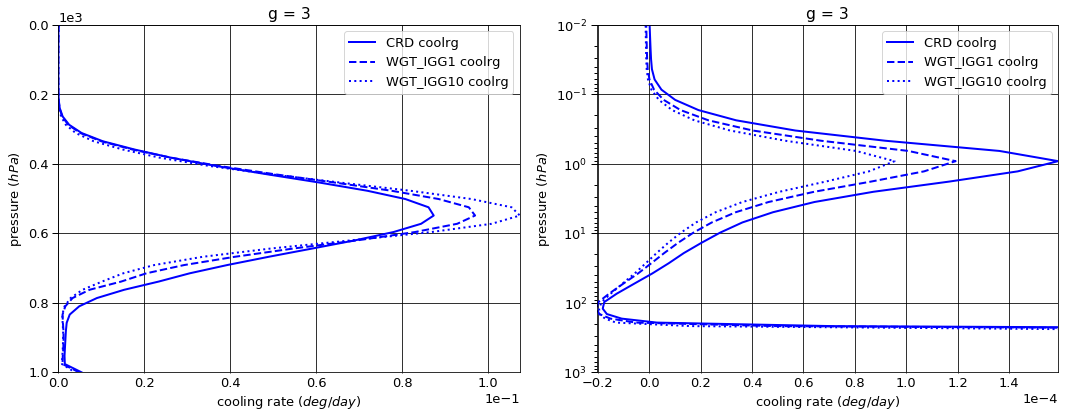

# Figure: cooling rate g-group 4

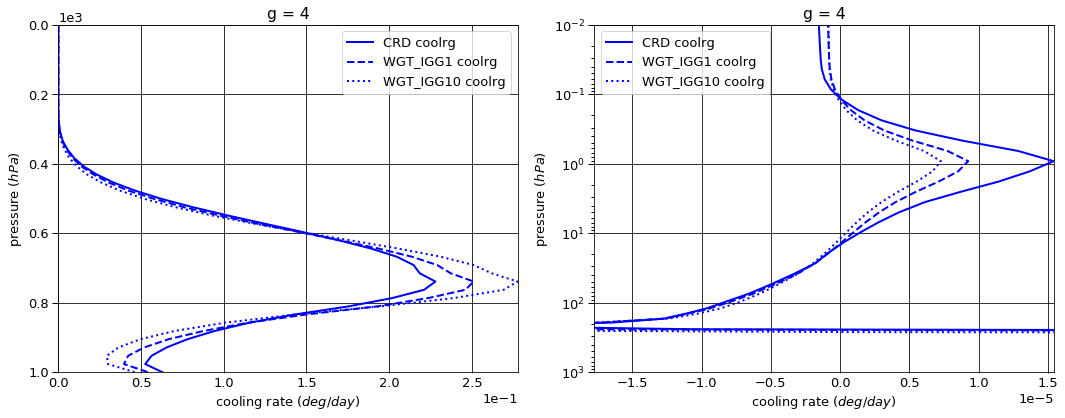

# Figure: cooling rate g-group 5

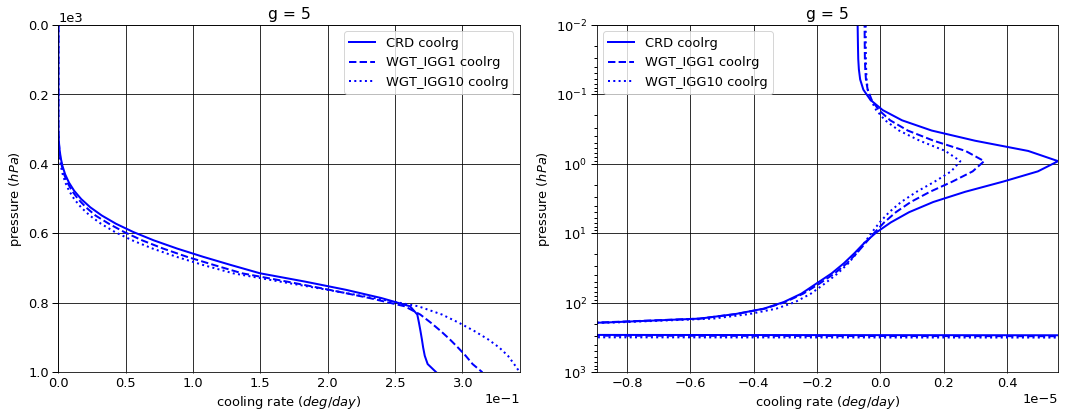

# Figure: cooling rate g-group 6

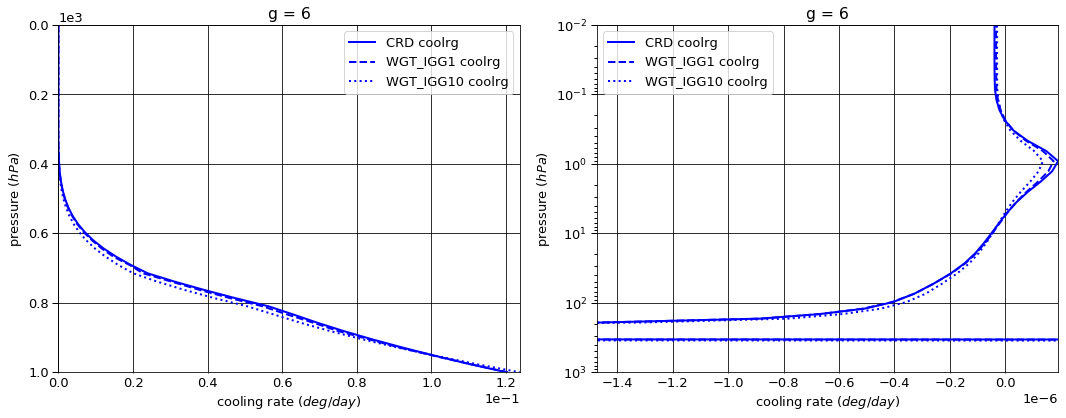

# Figure: cooling rate g-group total

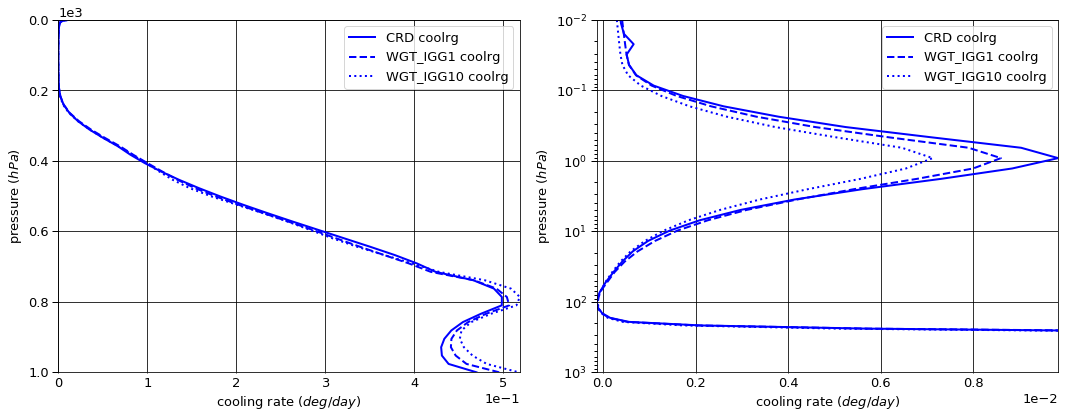

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.155699   0.000000  -0.155699
  1013.0   76     -0.356747   0.356484  -0.000263
2 0.0      1      -0.961479   0.000000  -0.961479
  1013.0   76     -1.817465   1.816088  -0.001377
3 0.0      1      -2.875852   0.000000  -2.875852
  1013.0   76     -4.378528   4.363938  -0.014590
4 0.0      1      -9.215691   0.000000  -9.215691
  1013.0   76    -11.692770  11.340162  -0.352608
5 0.0      1     -16.585694   0.000000 -16.585694
  1013.0   76    -18.299563  12.459439  -5.840124
6 0.0      1     -10.176924   0.000000 -10.176924
  1013.0   76    -10.522476   3.144804  -7.377673


WGT_IGG1


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.151646   0.000000  -0.151646
  1013.0   76     -0.356747   0.356484  -0.000263
2 0.0      1      -0.942282   0.000000  -0.942282
  1013.0   76     -1.817465   1.816096  -0.001369
3 0.0      1      -2.837923   0.000000  -2.837923
  1013.0   76     -4.378528   4.366076  -0.012452
4 0.0      1      -9.191851   0.000000  -9.191851
  1013.0   76    -11.692770  11.474451  -0.218319
5 0.0      1     -16.654323   0.000000 -16.654323
  1013.0   76    -18.299563  12.527051  -5.772512
6 0.0      1     -10.183871   0.000000 -10.183871
  1013.0   76    -10.522476   3.095740  -7.426736


WGT_IGG10


flug       fldg      fnetg
g pressure level                                 
1 0.0      1      -0.151292   0.000000  -0.151292
  1013.0   76     -0.356747   0.356484  -0.000263
2 0.0      1      -0.939950   0.000000  -0.939950
  1013.0   76     -1.817465   1.816096  -0.001369
3 0.0      1      -2.831988   0.000000  -2.831988
  1013.0   76     -4.378528   4.368702  -0.009826
4 0.0      1      -9.185272   0.000000  -9.185272
  1013.0   76    -11.692770  11.513612  -0.179157
5 0.0      1     -16.686030   0.000000 -16.686030
  1013.0   76    -18.299563  12.918684  -5.380879
6 0.0      1     -10.212748   0.000000 -10.212748
  1013.0   76    -10.522476   2.960560  -7.561916


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.053470e-03  0.000000  0.004053
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      1.919633e-02  0.000000  0.019196
  1013.0   76     2.220446e-16  0.000009  0.000009
3 0.0      1      3.792880e-02  0.000000  0.037929
  1013.0   76     0.000000e+00  0.002138  0.002138
4 0.0      1      2.383970e-02  0.000000  0.023840
  1013.0   76     0.000000e+00  0.134289  0.134290
5 0.0      1     -6.862900e-02  0.000000 -0.068629
  1013.0   76     0.000000e+00  0.067612  0.067612
6 0.0      1     -6.947000e-03  0.000000 -0.006947
  1013.0   76     0.000000e+00 -0.049064 -0.049064


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      4.406950e-03  0.000000  0.004407
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      2.152880e-02  0.000000  0.021529
  1013.0   76     2.220446e-16  0.000009  0.000009
3 0.0      1      4.386390e-02  0.000000  0.043864
  1013.0   76     0.000000e+00  0.004764  0.004764
4 0.0      1      3.041870e-02  0.000000  0.030419
  1013.0   76     0.000000e+00  0.173450  0.173451
5 0.0      1     -1.003360e-01  0.000000 -0.100336
  1013.0   76     0.000000e+00  0.459245  0.459245
6 0.0      1     -3.582400e-02  0.000000 -0.035824
  1013.0   76     0.000000e+00 -0.184244 -0.184244

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.442548e-04
  1001.112500 75     9.440476e-05
2 0.000312    1      2.318726e-05
  1001.112500 75     4.993789e-04
3 0.000312    1     -7.354332e-07
  1001.112500 75     5.381638e-03
4 0.000312    1     -1.785564e-06
  1001.112500 75     6.303640e-02
5 0.000312    1     -7.391738e-07
  1001.112500 75     2.807184e-01
6 0.000312    1     -3.811387e-08
  1001.112500 75     1.201473e-01


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.280854e-04
  1001.112500 75     9.440476e-05
2 0.000312    1      2.442512e-06
  1001.112500 75     4.905756e-04
3 0.000312    1     -1.662288e-06
  1001.112500 75     4.821172e-03
4 0.000312    1     -1.002681e-06
  1001.112500 75     5.443039e-02
5 0.000312    1     -5.063597e-07
  1001.112500 75     3.149814e-01
6 0.000312    1     -3.247004e-08
  1001.112500 75     1.205371e-01


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.605087e-04
  1001.112500 75     9.440476e-05
2 0.000312    1     -7.215240e-06
  1001.112500 75     4.905756e-04
3 0.000312    1     -1.736637e-06
  1001.112500 75     3.862794e-03
4 0.000312    1     -9.526307e-07
  1001.112500 75     4.640445e-02
5 0.000312    1     -4.632745e-07
  1001.112500 75     3.427962e-01
6 0.000312    1     -2.872350e-08
  1001.112500 75     1.237133e-01


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      8.383060e-05
  1001.112500 75    -1.355253e-20
2 0.000312    1     -2.074475e-05
  1001.112500 75    -8.803320e-06
3 0.000312    1     -9.268552e-07
  1001.112500 75    -5.604665e-04
4 0.000312    1      7.828834e-07
  1001.112500 75    -8.606011e-03
5 0.000312    1      2.328140e-07
  1001.112500 75     3.426304e-02
6 0.000312    1      5.643831e-09
  1001.112500 75     3.898100e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.625389e-05
  1001.112500 75    -1.355253e-20
2 0.000312    1     -3.040250e-05
  1001.112500 75    -8.803320e-06
3 0.000312    1     -1.001204e-06
  1001.112500 75    -1.518844e-03
4 0.000312    1      8.329334e-07
  1001.112500 75    -1.663195e-02
5 0.000312    1      2.758993e-07
  1001.112500 75     6.207777e-02
6 0.000312    1      9.390374e-09
  1001.112500 75     3.566000e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-39.971338,0.000000,-39.971338
1013.0,76,-47.067549,33.480914,-13.586636



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-39.961896,0.000000,-39.961896
1013.0,76,-47.067549,33.635898,-13.431651



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-40.007280,0.000000,-40.007280
1013.0,76,-47.067549,33.934138,-13.133411



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.009442,0.000000,0.009442
1013.0,76,0.000000,0.154984,0.154985



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.035942,0.000000,-0.035942
1013.0,76,0.000000,0.453224,0.453225


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000164
1001.112500,75,0.469878



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000227
1001.112500,75,0.495355



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000150
1001.112500,75,0.517362



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000063
1001.112500,75,0.025478



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000014
1001.112500,75,0.047484


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.00750,0.007722
2,0.03850,0.038815
3,0.09275,0.093538
4,0.24780,0.249559
5,0.38800,0.390004
6,0.22545,0.220362


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.620340e-21
2,2.553906e-22
3,4.025348e-23
4,6.344568e-24
5,1.000002e-24
6,1.307067e-25


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.620340e-21,NaN,0.00750,0.007722,0.00750,0.007722,600.0
2,2.553906e-22,0.157615,0.03850,0.038815,0.04600,0.046537,600.0
3,4.025348e-23,0.157615,0.09275,0.093538,0.13875,0.140075,600.0
4,6.344568e-24,0.157615,0.24780,0.249559,0.38655,0.389634,600.0
5,1.000002e-24,0.157615,0.38800,0.390004,0.77455,0.779638,600.0
6,1.307067e-25,0.130706,0.22545,0.220362,1.00000,1.000000,600.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     4.031427e-21  1.000322e-22  40.301298  2.245429e-07
      2 0.000312     1.725041e-22  3.583392e-24  48.139885  9.598509e-09
      3 0.000312     2.117034e-24  1.724057e-25  12.279371  1.195737e-10
      4 0.000312     2.884004e-25  2.346634e-26  12.289959  1.262273e-11
      5 0.000312     6.244908e-26  4.445870e-27  14.046538  2.715690e-12
      6 0.000312     3.916366e-27  4.116818e-28   9.513091  2.467367e-13
2     1 0.000750     4.061774e-21  1.002015e-22  40.536046  9.112045e-08
      2 0.000750     1.737234e-22  3.590997e-24  48.377480  3.893380e-09
      3 0.000750     2.144434e-24  1.730565e-25  12.391520  4.877725e-11
      4 0.000750     2.898175e-25  2.356408e-26  12.299120  5.109056e-12
      5 0.000750     6.295129e-26  4.465507e-27  14.097232  1.102461e-12
      6 0.000750     3.950249e-27  4.150321e-28   9.517937  1.002415e-13
3     1 0.001052     4.123962e-21  1.005084e-22  41.031028  1.297329e-07
      2 0.001052     1.762245e-22  3.604400e-24  48.891480  5.538328e-09
      3 0.001052     2.200654e-24  1.741993e-25  12.632965  7.017134e-11
      4 0.001052     2.927178e-25  2.375118e-26  12.324350  7.235807e-12
      5 0.001052     6.398183e-26  4.503140e-27  14.208272  1.570830e-12
      6 0.001052     4.019459e-27  4.215434e-28   9.535102  1.430372e-13
4     1 0.001476     4.187810e-21  1.008293e-22  41.533646  1.848055e-07
      2 0.001476     1.787943e-22  3.618690e-24  49.408567  7.882559e-09
      3 0.001476     2.259357e-24  1.754066e-25  12.880682  1.010311e-10
      4 0.001476     2.957118e-25  2.394506e-26  12.349595  1.025381e-11
      5 0.001476     6.504516e-26  4.541719e-27  14.321706  2.239534e-12
      6 0.001476     4.090898e-27  4.283132e-28   9.551183  2.042283e-13
5     1 0.002070     4.252466e-21  1.011640e-22  42.035353  2.631889e-07
      2 0.002070     1.813988e-22  3.633930e-24  49.918065  1.121645e-08
      3 0.002070     2.319869e-24  1.766811e-25  13.130261  1.454474e-10
      4 0.002070     2.987621e-25  2.414448e-26  12.373931  1.452874e-11
      5 0.002070     6.612766e-26  4.580949e-27  14.435364  3.192298e-12
      6 0.002070     4.163680e-27  4.352891e-28   9.565321  2.915392e-13
6     1 0.002904     4.317905e-21  1.015174e-22  42.533629  3.748402e-07
      2 0.002904     1.840370e-22  3.650440e-24  50.415003  1.596178e-08
      3 0.002904     2.382271e-24  1.780461e-25  13.380080  2.094396e-10
      4 0.002904     3.018702e-25  2.435108e-26  12.396585  2.059011e-11
      5 0.002904     6.722942e-26  4.621112e-27  14.548320  4.551005e-12
      6 0.002904     4.237851e-27  4.425177e-28   9.576682  4.162325e-13
7     1 0.004074     4.384104e-21  1.018966e-22  43.025032  5.338417e-07
      2 0.004074     1.867081e-22  3.668674e-24  50.892526  2.271469e-08
      3 0.004074     2.446679e-24  1.795349e-25  13.627878  3.016389e-10
      4 0.004074     3.050388e-25  2.456725e-26  12.416481  2.918405e-11
      5 0.004074     6.835076e-26  4.662626e-27  14.659286  6.488357e-12
      6 0.004074     4.313491e-27  4.500675e-28   9.584097  5.942960e-13
8     1 0.005714     4.451082e-21  1.023118e-22  43.505069  7.602007e-07
      2 0.005714     1.894129e-22  3.689282e-24  51.341400  3.232163e-08
      3 0.005714     2.513285e-24  1.811947e-25  13.870632  4.344840e-10
      4 0.005714     3.082734e-25  2.479651e-26  12.432129  4.136731e-11
      5 0.005714     6.949282e-26  4.706107e-27  14.766520  9.250235e-12
      6 0.005714     4.390755e-27  4.580414e-28   9.585935  8.485371e-13
9     1 0.008015     4.518778e-21  1.027773e-22  43.966714  1.082498e-06
      2 0.008015     1.921490e-22  3.713168e-24  51.747983  4.599118e-08
      3 0.008015     2.582262e-24  1.830906e-25  14.103741  6.260003e-10
      4 0.008015     3.115775e-25  2.504358e-26  12.441412  5.864625e-11
      5 0.008015     7.065568e-26  4.752387e-27  14.867408  1.318870e-11
      6 0.0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
